In [1]:
# !pip install yfinance
!pip install --user statsmodels

In [39]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# Fetch Tesla stock data
tesla = yf.Ticker("TSLA")

# Get historical data (adjust the start and end dates as needed)
data_stock = tesla.history(start="2019-01-01", end="2024-01-04")

In [19]:
# Information About Dataset
print(data_stock.head())
print(data_stock.info())
print(data_stock.shape)


                                Open       High        Low      Close  \
Date                                                                    
2019-01-02 00:00:00-05:00  20.406668  21.008667  19.920000  20.674667   
2019-01-03 00:00:00-05:00  20.466667  20.626667  19.825333  20.024000   
2019-01-04 00:00:00-05:00  20.400000  21.200001  20.181999  21.179333   
2019-01-07 00:00:00-05:00  21.448000  22.449333  21.183332  22.330667   
2019-01-08 00:00:00-05:00  22.797333  22.934000  21.801332  22.356667   

                              Volume  Dividends  Stock Splits  
Date                                                           
2019-01-02 00:00:00-05:00  174879000        0.0           0.0  
2019-01-03 00:00:00-05:00  104478000        0.0           0.0  
2019-01-04 00:00:00-05:00  110911500        0.0           0.0  
2019-01-07 00:00:00-05:00  113268000        0.0           0.0  
2019-01-08 00:00:00-05:00  105127500        0.0           0.0  
<class 'pandas.core.frame.DataFrame'>
Da

In [20]:
# checking for null values
print(data_stock.isnull().sum())

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


In [21]:
# Remove duplicate rows
data_stock.drop_duplicates(inplace=True)

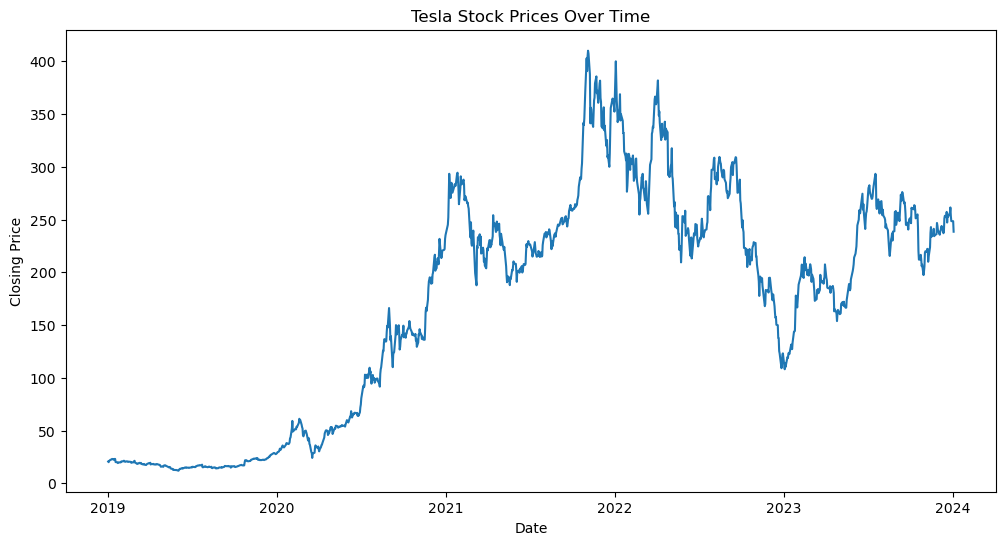

In [23]:
# Time Series Analysis
plt.figure(figsize=(12, 6))
plt.plot(data_stock.index, data_stock['Close'], label='Tesla Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Tesla Stock Prices Over Time')
plt.show()

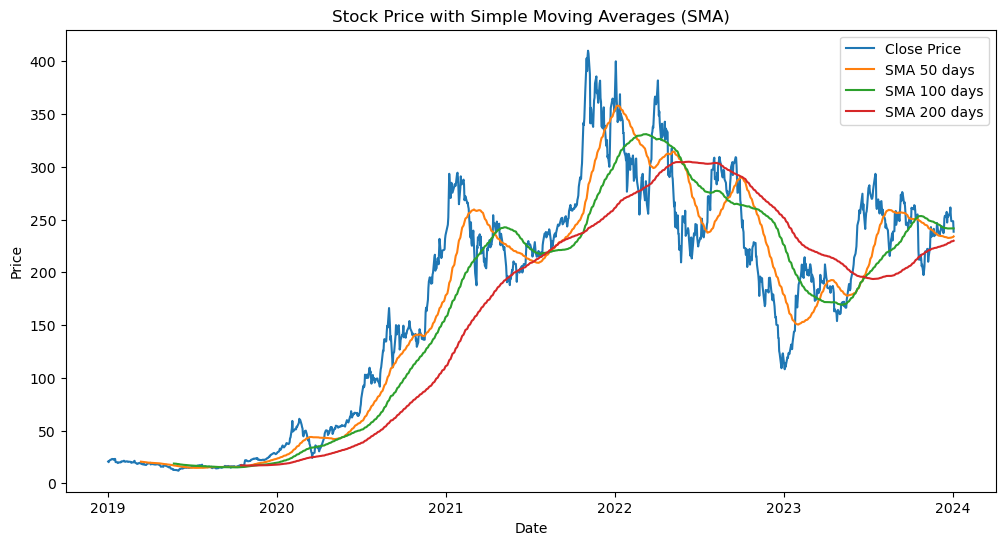

In [27]:
# Calculate Simple Moving Averages (SMA)
sma_50 = data_stock['Close'].rolling(window=50).mean()
sma_100 = data_stock['Close'].rolling(window=100).mean()
sma_200 = data_stock['Close'].rolling(window=200).mean()

# Plotting the stock prices and SMAs
plt.figure(figsize=(12, 6))
plt.plot(data_stock.index, data_stock['Close'], label='Close Price')
plt.plot(data_stock.index, sma_50, label='SMA 50 days')
plt.plot(data_stock.index, sma_100, label='SMA 100 days')
plt.plot(data_stock.index, sma_200, label='SMA 200 days')

plt.title('Stock Price with Simple Moving Averages (SMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

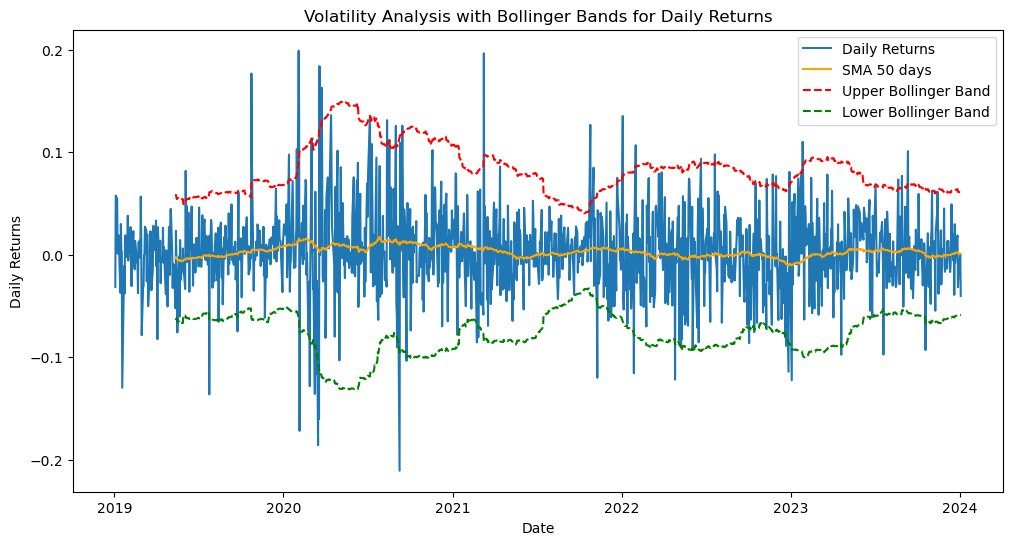

In [29]:
# Volatility Analysis with Bollinger Bands:
# Calculate daily returns
daily_returns = data_stock['Close'].pct_change()

# Calculate 20-day Simple Moving Average (SMA) and standard deviation of daily returns
sma_50 = daily_returns.rolling(window=90).mean()
std_50 = daily_returns.rolling(window=90).std()

# Calculate Upper and Lower Bollinger Bands for daily returns
upper_band = sma_50 + 2 * std_50
lower_band = sma_50 - 2 * std_50

# Plotting the daily returns and Bollinger Bands
plt.figure(figsize=(12, 6))
plt.plot(daily_returns.index, daily_returns, label='Daily Returns')
plt.plot(sma_50.index, sma_50, label='SMA 50 days', color='orange')
plt.plot(upper_band.index, upper_band, label='Upper Bollinger Band', color='red', linestyle='--')
plt.plot(lower_band.index, lower_band, label='Lower Bollinger Band', color='green', linestyle='--')

plt.title('Volatility Analysis with Bollinger Bands for Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.show()

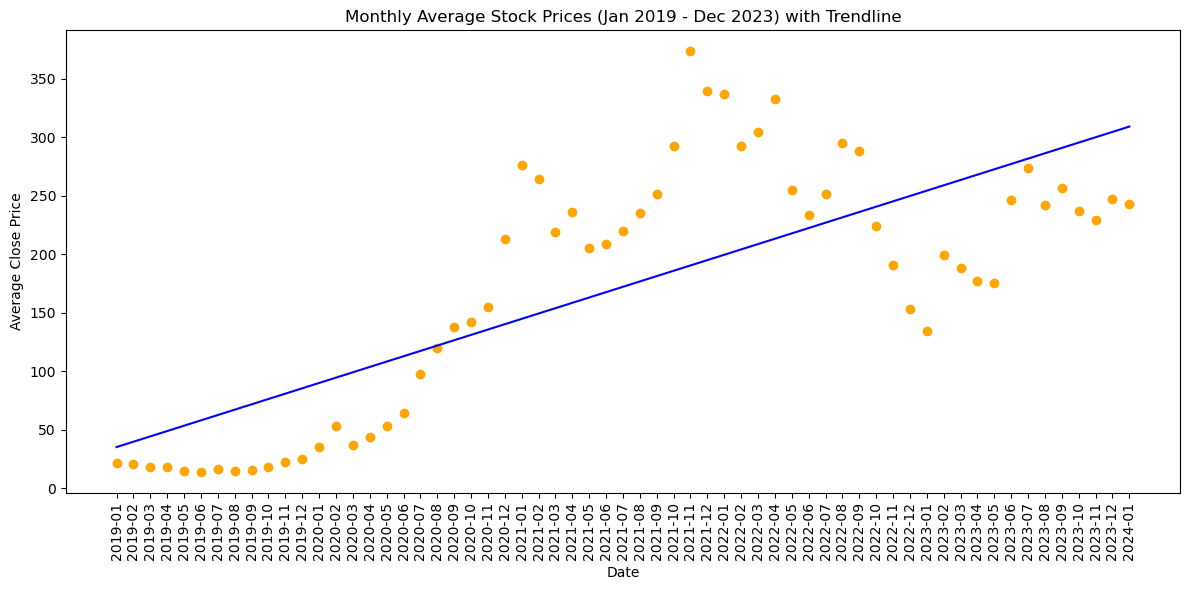

In [41]:
# Monthly Seasonal Analysis

# Resample the data to get monthly averages
monthly_avg = data_stock['Close'].resample('M').mean()

# Extracting month and year for scatter plot
monthly_avg.index = monthly_avg.index.strftime('%Y-%m')

# Creating x and y values for the trendline
x_values = np.arange(len(monthly_avg))
y_values = monthly_avg.values

# Calculate linear regression (trendline)
coefficients = np.polyfit(x_values, y_values, 1)
trendline = coefficients[0] * x_values + coefficients[1]

# Plotting the scatter plot of monthly average stock prices with trendline
plt.figure(figsize=(12, 6))
plt.scatter(monthly_avg.index, monthly_avg.values, color='orange', label='Monthly Avg Prices')
plt.plot(monthly_avg.index, trendline, color='blue', label='Trendline')
plt.title(f'Monthly Average Stock Prices (Jan 2019 - Dec 2023) with Trendline')
plt.xlabel('Date')
plt.ylabel('Average Close Price')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [59]:
# Predict prices for the month of January 2024 based on the historical data
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime, timedelta


# Extract the 'Close' prices
data = data_stock['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare the dataset
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_steps = 60  # Number of time steps to consider for prediction
X, y = create_dataset(scaled_data, time_step=time_steps)

# Reshape data for LSTM (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X, y, epochs=100, batch_size=32)

# Predicting the next month stock prices
last_month = scaled_data[-time_steps:]
last_month = last_month.reshape(1, time_steps, 1)

predicted_prices = []
for i in range(30):  # Predicting 30 days (1 month) ahead
    prediction = model.predict(last_month)
    predicted_prices.append(prediction[0, 0])
    last_month = np.append(last_month[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Inverse transform the predicted prices to original scale
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Generate dates for the next month
last_date = data_stock.index[-1]  # Assuming the index contains date information
predicted_dates = [last_date + pd.DateOffset(days=i) for i in range(1, 31)]

# Create a DataFrame for predicted prices and dates
predicted_data_stock = pd.DataFrame({'Date': predicted_dates, 'Predicted Close': predicted_prices.flatten()})
print(predicted_data_stock)


Epoch 1/100
38/38 [==============================] - 10s 61ms/step - loss: 0.0224
Epoch 2/100
38/38 [==============================] - 2s 60ms/step - loss: 0.0026
Epoch 3/100
38/38 [==============================] - 2s 59ms/step - loss: 0.0022
Epoch 4/100
38/38 [==============================] - 2s 60ms/step - loss: 0.0021
Epoch 5/100
38/38 [==============================] - 2s 60ms/step - loss: 0.0018
Epoch 6/100
38/38 [==============================] - 2s 60ms/step - loss: 0.0016
Epoch 7/100
38/38 [==============================] - 2s 60ms/step - loss: 0.0015
Epoch 8/100
38/38 [==============================] - 2s 60ms/step - loss: 0.0014
Epoch 9/100
38/38 [==============================] - 2s 60ms/step - loss: 0.0013
Epoch 10/100
38/38 [==============================] - 2s 60ms/step - loss: 0.0013
Epoch 11/100
38/38 [==============================] - 2s 59ms/step - loss: 0.0013
Epoch 12/100
38/38 [==============================] - 2s 54ms/step - loss: 0.0011
Epoch 13/100
38/38 [====

38/38 [==============================] - 2s 60ms/step - loss: 4.4529e-04
Epoch 98/100
38/38 [==============================] - 2s 59ms/step - loss: 4.4998e-04
Epoch 99/100
38/38 [==============================] - 2s 54ms/step - loss: 4.4638e-04
Epoch 100/100
1/1 [==============================] - 0s 51ms/step
                        Date  Predicted Close
0  2024-01-04 00:00:00-05:00       240.245621
1  2024-01-05 00:00:00-05:00       239.875320
2  2024-01-06 00:00:00-05:00       239.887253
3  2024-01-07 00:00:00-05:00       239.622772
4  2024-01-08 00:00:00-05:00       239.249664
5  2024-01-09 00:00:00-05:00       238.939682
6  2024-01-10 00:00:00-05:00       238.772659
7  2024-01-11 00:00:00-05:00       238.763992
8  2024-01-12 00:00:00-05:00       238.899658
9  2024-01-13 00:00:00-05:00       239.157547
10 2024-01-14 00:00:00-05:00       239.516907
11 2024-01-15 00:00:00-05:00       239.960495
12 2024-01-16 00:00:00-05:00       240.474045
13 2024-01-17 00:00:00-05:00       241.045410

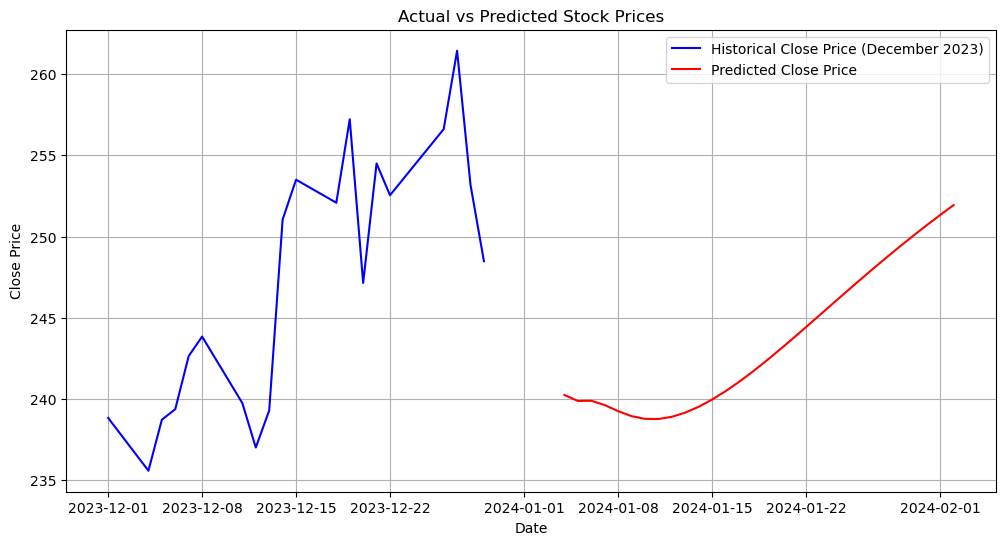

In [61]:
# Filter historical data for December 2023
december_2023_data = data_stock[( data_stock.index.month == 12) & ( data_stock.index.year == 2023)]

# Plotting the historical data for December 2023
plt.figure(figsize=(12, 6))
plt.plot(december_2023_data.index, december_2023_data['Close'], label='Historical Close Price (December 2023)', color='blue')
# Plotting the predicted prices for the next month
plt.plot(predicted_data_stock['Date'], predicted_data_stock['Predicted Close'], label='Predicted Close Price', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [63]:
# Finding Percent Difference in the predicted prices for the month of January 2024

if not predicted_data_stock.empty:
    # Calculate percent change
    predicted_prices_jan_2023 = predicted_data_stock['Predicted Close'].values
    percent_change_jan_2023 = ((predicted_prices_jan_2023[-1] - predicted_prices_jan_2023[0]) / predicted_prices_jan_2023[0]) * 100

    print(f"Predicted percent change for January 2023: {percent_change_jan_2023:.2f}%")
else:
    print("No data available for January 2023 in the predictions.")


Predicted percent change for January 2023: 4.87%
